# Predicting *sound pressure* in Airfoil Self-Noise using TensorFlow

In this dataset, we will be predicting the sound pressure in decibels from different sizes of NACA 0012 airfoils at various wind tunner speeds and angles of attack. The dataset can be downloaded from [Data](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise#).

In this notebook, we will be roughly following the below structure to model our problem of predicting sound pressure:
* Load the data.
* Display useful statistics.
* Build generic functions to detect nulls and missing values.
* Handle missing values.
* Make Visualizations to understand data better.
* Build a Multivariate Regression model.

<img src = "https://acoustics.org/wp-content/uploads/2019/12/Figure_01_Airplane_Sketch-980x551.jpg" width = "450" height = "450">
<br><br>
<a href = "https://acoustics.org/2asa9-acoustic-black-holes-in-airfoils-kaushik-sampath/">Image Source</a>




#### Data Set Information:

The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments. 

**Load Libraries**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import sys
import pandas as pd
import missingno as msno
import seaborn as sns
import pandas as pd 
pd.options.mode.chained_assignment = None
from IPython.core.display import HTML, display

Instructions for updating:
non-resource variables are not supported in the long term


### Load Dataset

In [4]:
# Read input data file stored as .dat
air_df = pd.read_csv('airfoil_self_noise.dat' , sep = '\t')

print(air_df.head(5))



    800    0  0.3048  71.3  0.00266337  126.201
0  1000  0.0  0.3048  71.3    0.002663  125.201
1  1250  0.0  0.3048  71.3    0.002663  125.951
2  1600  0.0  0.3048  71.3    0.002663  127.591
3  2000  0.0  0.3048  71.3    0.002663  127.461
4  2500  0.0  0.3048  71.3    0.002663  125.571


**Attribute Information:**

This problem has the following **independant** variables:
* Frequency, in Hertzs.
* Angle of attack, in degrees.
* Chord length, in meters.
* Free-stream velocity, in meters per second.
* Suction side displacement thickness, in meters.

**Target variable:**
* Scaled sound pressure level, in decibels. 

The raw dataset does not come with descriptive columns and seeing the attribute description given, we can name our columns.

In [5]:
# Add column names
column_names = ['frequency' , 'angle_of_attack' , 'chord_length', 'free_stream_velocity' , 'suction_thickness', 'sound_pressure_level']

air_df.columns = column_names

print(air_df.head(5))


   frequency  angle_of_attack  chord_length  free_stream_velocity  \
0       1000              0.0        0.3048                  71.3   
1       1250              0.0        0.3048                  71.3   
2       1600              0.0        0.3048                  71.3   
3       2000              0.0        0.3048                  71.3   
4       2500              0.0        0.3048                  71.3   

   suction_thickness  sound_pressure_level  
0           0.002663               125.201  
1           0.002663               125.951  
2           0.002663               127.591  
3           0.002663               127.461  
4           0.002663               125.571  


### Display Summary Statistics

In [6]:
# Describe the dataset
air_df.describe()

,frequency,angle_of_attack,chord_length,free_stream_velocity,suction_thickness,sound_pressure_level
count,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000
mean,2887.769640,6.786818,0.136436,50.847137,0.011146,124.835034
std,3153.162983,5.917509,0.093471,15.569029,0.013153,6.900864
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.190000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.719000
75%,4000.000000,9.900000,0.228600,71.300000,0.015840,129.997750
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [7]:
# No of records and features
print('Total rows: {} \t  Features: {}'.format(air_df.shape[0] , air_df.shape[1]))

Total rows: 1502 	  Features: 6


We have a total of *1502* records with *5* features and *1* target variable. As the number of features is not huge we can include them in our model definition.

In [8]:
# Display the column data types
print(air_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
frequency               1502 non-null int64
angle_of_attack         1502 non-null float64
chord_length            1502 non-null float64
free_stream_velocity    1502 non-null float64
suction_thickness       1502 non-null float64
sound_pressure_level    1502 non-null float64
dtypes: float64(5), int64(1)
memory usage: 70.5 KB
None


Notice that all the features are numerical and the target feature *sound_pressure_level* is continuous. This gives us an idea on the expected nature of our predicted values.

### Check for Missing Values
In this portion, we will develop a general function that calculates zero values, missing values, % of missing of values and NA's. This function is generic enought to be adapted to any dataframe.

In [9]:
def calcMissingValues(df: pd.DataFrame)-> pd.DataFrame:
    
    '''
    This function is used to calculate : zero values, missing values, NA and returns a dataframe with the above calculated
    values. Pass a dataframe to this function.
    
    '''
    
    # Calc zero values
    zero_vals = (df == 0.0).astype(int).sum(axis = 0)
    
    # Calc missing values
    missing_vals = df.isnull().sum()
    
    # Calc percentage of missing values
    missing_val_percent = (missing_vals / len(df)) * 100.0
    
    df_miss_val = pd.concat([zero_vals , missing_vals , missing_val_percent] , axis = 1)
    
    # rename columns
    df_miss_val = df_miss_val.rename(columns = {0: 'zero_vals' , 1: 'missing_vals' , 2: '%_missing_vals'})
    
    # Add datatype columns
    df_miss_val['data_type'] = df.dtypes
    
    return df_miss_val
    

In [10]:
df_miss_val = calcMissingValues(air_df)

print(df_miss_val)

                      zero_vals  missing_vals  %_missing_vals data_type
frequency                     0             0             0.0     int64
angle_of_attack             328             0             0.0   float64
chord_length                  0             0             0.0   float64
free_stream_velocity          0             0             0.0   float64
suction_thickness             0             0             0.0   float64
sound_pressure_level          0             0             0.0   float64


There are no null values in this dataset. There are about 328 zero values for *angle_of_attack*. They cannot be deleted as an angle of 0 degreees holds meaning compared to a numerical zero without any unit.

### EDA & Data Visualization
Let us visualize a pair wise plot of the data set to see if we can extract or observe any patterns between the features.

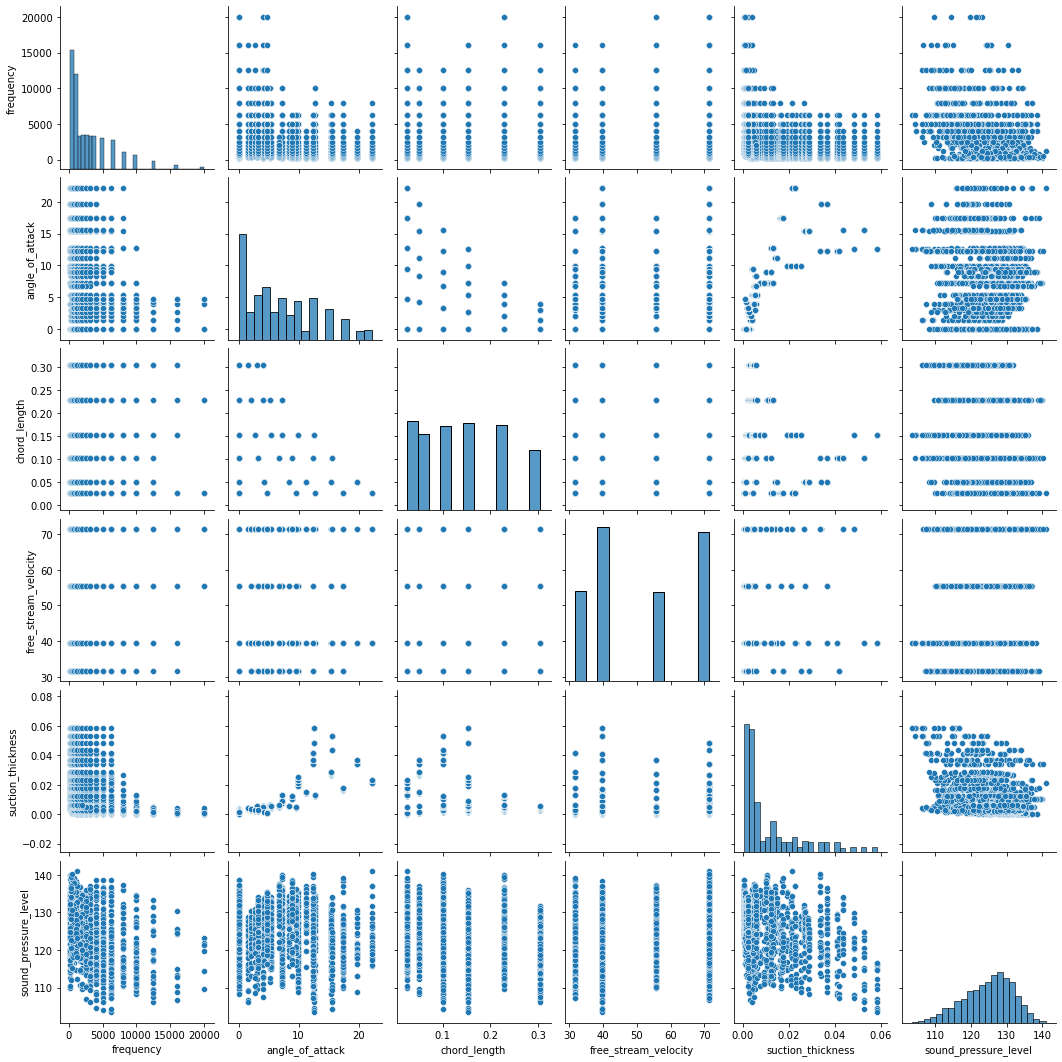

In [11]:
# Make a copy of the dataset
air_df_train = air_df.copy()

sns.pairplot(air_df_train)
plt.show()

In [12]:
## https://www.kaggle.com/shtrausslearning/gaussian-processes-airfoil-noise-modeling

**Correlation Matrix**

This will give us the correlation coeffecients between the variables. The values will give an idea of how the features are correlated with each other and with the target. Positive score indicates a strong relation and a negative score means there is less or no correlation

In [13]:
# Display correlation of features with the target variable sound_pressure_level

print(air_df_train.corrwith(air_df_train['sound_pressure_level']).sort_values(ascending = False))


sound_pressure_level    1.000000
free_stream_velocity    0.125003
angle_of_attack        -0.156027
chord_length           -0.236657
suction_thickness      -0.312632
frequency              -0.390686
dtype: float64


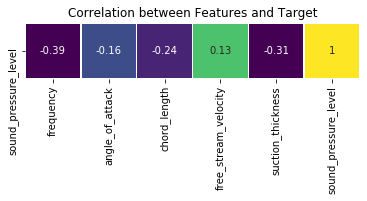

In [14]:
corr = air_df_train.corr().round(2)
#corr_mat = corr.transpose()
corr_mat = corr.loc[: , corr.columns == 'sound_pressure_level'].transpose().copy()
#print(corr.loc[: , corr.columns == 'sound_pressure_level'].transpose())
#print(corr_mat.shape)

sns.heatmap(corr_mat , vmin = -0.3 , vmax = 0.3 , cmap = 'viridis' , 
            center = 0, square = True, lw = 0.5,annot = True, cbar = False)
plt.title('Correlation between Features and Target')
plt.show()

In [15]:
print(air_df_train['chord_length'].unique())

[0.3048 0.2286 0.1524 0.0508 0.0254 0.1016]


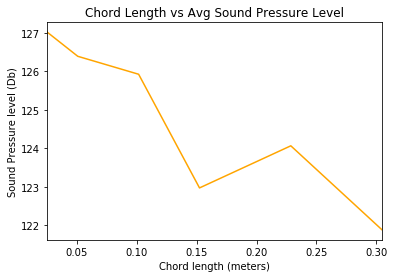

In [16]:
chord_sound_pressure = air_df_train.groupby(['chord_length'])['sound_pressure_level'].mean()

chord_sound_pressure.plot(x = 'chord_length' , y = 'sound_pressure_level', legend = False , color = 'orange')
plt.title('Chord Length vs Avg Sound Pressure Level')
plt.xlabel('Chord length (meters)')
plt.ylabel('Sound Pressure level (Db)' )
plt.show()

Plotting the *chord_length* against the target *sound_pressure_level* shows an interesting trend. The sound level decreases with increase in chord length with a sporadic rise at the length of *0.25 meters*

We saw in the correlation matrix plot that there is a positive correlation between *velocity* and the *sound pressure level*, let us make a plot and try to infer more about that correlation.

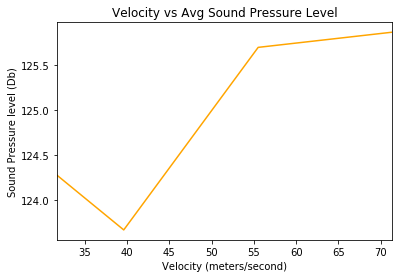

In [17]:
#print(air_df_train['free_stream_velocity'].unique())

#print(air_df_train[['free_stream_velocity' , 'sound_pressure_level']])

velocity_sound_pressure = air_df_train.groupby(['free_stream_velocity'])['sound_pressure_level'].mean()

velocity_sound_pressure.plot(x = 'free_stream_velocity' , y = 'sound_pressure_level', legend = False , color = 'orange')
plt.title('Velocity vs Avg Sound Pressure Level')
plt.xlabel('Velocity (meters/second)')
plt.ylabel('Sound Pressure level (Db)' )
plt.show()


The general trend seems to suggest a positive linear relationship (i.e.) with an increase in velocity, the sound pressure seems to rise as well.

In this dataset there is not many features to visualize and so will next look at building a predictive model to predict sound pressure levels. As the output is going to be continuous, we will develop a **Multivariate Linear Regression** model.

## Multivariate Linear Regression


Linear Regression is a supervised learning algorithm used to predict a continuous valued output. In this problem, the target or the depandant variable is continuous.

**Mathematical definition**:

There are two ways of modelling a a Linear Regression solution:
* Univariate Regression
* Multivariate Regresion

In **Univariate Regression** the number of predictor (p) or independant features is $1$ and is defined by the following equation:


$y = b_{0} + b_{1}x$

where: $b_{0}$ and $b_{1}$ are the coefficients.

When the # of predictors p $> 1$, then we can model the problem using **Multivariate regression** which is defined by :

$y_{i} = b_{0} + \sum\limits_{j=1}^{p}b_{j}x_{ij} + e_{i}$

for $i \in {1,\ldots,n}$

Where

* $y_{i}$ is the target variable or response for the i-th observation
* $b_{0}$ is the regression intercept
* $b_{j}$ is the j-th slope intercept for the predictor or feature
* $x_{ij}$ is the j-th predictor for i-th observation

Now that we have defined our model, let us write code to implement the above equations and predict output sound pressure values using **Tensorflow**


**Normalize the data**

Since the model makes use of Gradient descent feature scaling helps to speed up the process.

In [18]:
def normalize(data: np.ndarray) -> np.ndarray:
    
    '''
    Function to mormailze the data having
    
    '''
    # Find the mean
    mean_arr = np.mean(data, axis = 0)
    
    # Find the standard deviation
    std_arr = np.std(data , axis = 0)
    
    # Normalize
    norm_data = (data - mean_arr) / std_arr
    
    return norm_data

In [26]:
norm_air_df = normalize(air_df_train)

In [27]:
# Separate dependant and independant variables

y_df = norm_air_df['sound_pressure_level']
x_df = norm_air_df.drop(['sound_pressure_level'] , axis = 1)


**Split the dataset into train and test sets**

In [102]:
# Split into train and test
def splitDataset(x_df: pd.DataFrame , y_df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
       
    mask = np.random.rand(len(x_df)) <= 0.8
    
    x_train = x_df[mask]
    x_test = x_df[~mask]
    
    y_train = y_df[mask]
    y_test = y_df[~mask]
    
    
    return x_train, y_train, x_test, y_test

In [104]:
# Define a random state for reproduceability
np.random.seed(123)

x_train, y_train, x_test, y_test = splitDataset(x_df , y_df)

print('X Train Shape: ', x_train.shape)
print('X Test Shape: ', x_test.shape)
print('Y Train Shape: ', y_train.shape)
print('Y Test Shape: ', y_test.shape)

X Train Shape:  (1191, 5)
X Test Shape:  (311, 5)
Y Train Shape:  (1191,)
Y Test Shape:  (311,)


In [105]:
# Convert dataframe to numpy arrays

x_train_arr = x_train.to_numpy()
y_train_arr = y_train.to_numpy()

x_test_arr = x_test.to_numpy()
y_test_arr = y_test.to_numpy()

print('X Train Shape: ', x_train_arr.shape)
print('X Test Shape: ', x_test_arr.shape)
print('Y Train Shape: ', y_train_arr.shape)
print('Y Test Shape: ', y_test_arr.shape)

X Train Shape:  (1191, 5)
X Test Shape:  (311, 5)
Y Train Shape:  (1191,)
Y Test Shape:  (311,)


In [106]:
# get row and column dimensions
r_dim , c_dim = x_train.shape

# Define Tensorflow placeholders for X and Y
x = tf.placeholder(tf.float32 , [None , c_dim] , name = 'x')
y = tf.placeholder(tf.float32 , [None] , name = 'y')

# Define placeholders for Weight and Bias
# Y = Xb + e (Matrix form)

# Define coeffecient and noise terms
b = tf.Variable(tf.random.normal([c_dim , 1] , dtype = tf.float32) , name = 'bias')
e = tf.Variable(tf.random.normal([1] , dtype = tf.float32) , name = 'noise')


# Define the model
y_pred = tf.add(tf.matmul(x , b) , e)


# Loss Function RMSE
loss = tf.reduce_mean(tf.square(y - y_pred , name = 'loss'))

In [107]:
learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

In [108]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [149]:
epochs = 1100
disp_freq = 100

feed_input = {x: x_train_arr , y: y_train_arr}

for epoch in range(epochs):
    
    sess.run(optimizer , feed_dict = feed_input)
    
    if epoch % disp_freq == 0:
        
        loss_val = sess.run(loss , feed_dict = feed_input)
        
        print('Epoch: {} \t Loss: {:.2f}'.format(epoch , loss_val))
    

    
y_pred_val = sess.run(y_pred , {x: x_test})

# print(y_pred_val , y_pred_val.shape)

rmse_acc = tf.reduce_mean(tf.square(y_pred_val[:, -1] - y_test))

print('RMSE acc: {:.2f}'.format(sess.run(rmse_acc)))


print('Test: {} \t\t Predicted: {}'.format(y_test.iloc[0] , y_pred_val[0]))





    
# feed_test = {x: x_test , y: y_test}
# loss_test = sess.run(loss , feed_dict = feed_test)

# print('Loss Test: {:.2f}'.format(loss_test))



Epoch: 0 	 Loss: 0.99
Epoch: 100 	 Loss: 0.99
Epoch: 200 	 Loss: 0.99
Epoch: 300 	 Loss: 0.99
Epoch: 400 	 Loss: 0.99
Epoch: 500 	 Loss: 0.99
Epoch: 600 	 Loss: 0.99
Epoch: 700 	 Loss: 0.99
Epoch: 800 	 Loss: 0.99
Epoch: 900 	 Loss: 0.99
Epoch: 1000 	 Loss: 0.99
RMSE acc: 1.03
Test: -0.25715979071996226 		 Predicted: [0.00747433]


The RMSE value is low which indicates a better fit by our model for this dataset. Let us plot the line of best fit

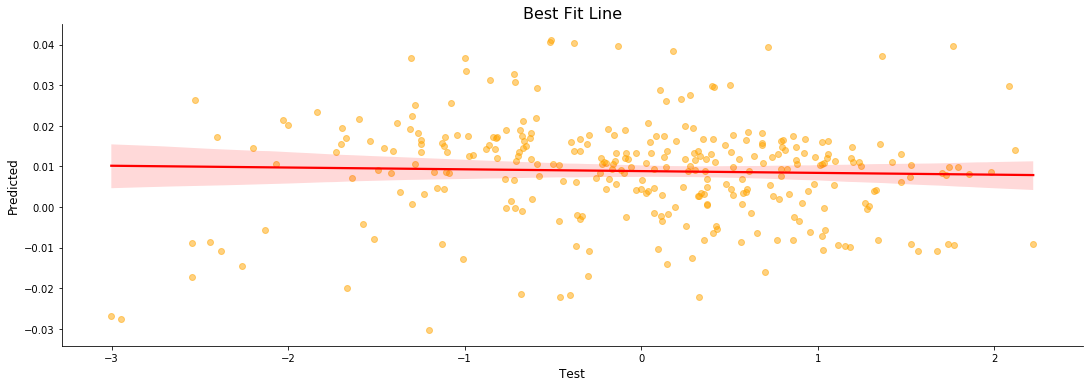

In [145]:
pred_df = pd.DataFrame({'y_test': y_test , 'y_pred': y_pred_val[: , -1]})

#print(pred_df)

sns.lmplot(x = 'y_test', y = 'y_pred', data = pred_df, height = 5, 
           aspect = 3 , scatter_kws = {'color' : 'orange' , 'alpha' : 0.5} , line_kws = {'color' : 'red'})
plt.xlabel('Test' , fontsize = 12)
plt.ylabel('Predicted' , fontsize = 12)
plt.title('Best Fit Line' , fontsize = 16)
plt.show()

The predictions are decent considering the non linearity of some of the features. This problem is used to show how Multivariate Regression can be modelled using TensorFlow. To get better accuracy, Polynomial regression can be used which will be explored in another notebook.